# Dynamic response of a prismatic cantilever wing to a ``1-cos'' gust. 

This is an example of the nonlinear dynamic aeroelastics solver in SHARPy. It solves either a rigid or a flexible wing under a uniform 1-cos gust profile. The wing can also be swept such that the gust enters through either the root (sweptback) or the tip (sweptforward).

It runs with SHARPy v.1.3 (www.imperial.ac.uk/aeroelastics/sharpy)

Latest update: 12.04.2022

NOTE: With the current settings to ensure fine convergence on multiple runs, this script takes about 5 hours on a desktop computer.

## Initialization
### Required packages
Import some python packages, SHARPy and some SHARPy utilities.

In [1]:
import numpy as np                         # basic mathematical and array functions
import os                                  # Functions related to the operating system
import matplotlib.pyplot as plt            # Plotting library

import sharpy.sharpy_main                  # Run SHARPy inside jupyter notebooks
import sharpy.utils.plotutils as pu        # Plotting utilities
import sharpy.utils.generate_cases as gc   # Automate model generation.
import sharpy.utils.algebra as algebra

plt.rcParams.update({'font.size': 20})     # Large fonts in all plots

### Initializing simulation environment

In [2]:
SimInfo = gc.SimulationInformation() # Initialises the SimulationInformation class
SimInfo.set_default_values()         # Assigns the default values to all the solvers

In [3]:
SimInfo.solvers['SHARPy']['route'] = 'output/'         # Folder where outputs are written.
SimInfo.solvers['SHARPy']['write_screen'] = 'off'

In [4]:
airfoil = gc.AeroelasticInformation()  # Initialize aeroelastic model.

## Problem definition

In [5]:
### Wing parameters

In [6]:
Rigid=False        # Toggle on/off to select simulation of a rigid or a flexible wing.

In [7]:
# Geometry
chord = 1.         # Wind chord (constant).
aspect_ratio = 16. # Ratio between chord and semispan: aspect_ratio = semispan/chord
wake_length = 25   # Length of the wake in chord lengths (25)

# Discretization
num_node = 21           # Number of nodes in the structural discretisation. They also define 
                        # the aerodynamic panels in the spanwise direction
num_chord_panels = 5    # Number of aerodynamic panels in the chordwise direction
num_points_camber = 20  # Number of points that define the camber line of the airfoil

# Structural properties of the beam cross section
mass_per_unit_length = 0.75 # Mass per unit length
mass_iner_x = 0.1           # Mass inertia around the local x axis
mass_iner_y = 0.001         # Mass inertia around the local y axis
mass_iner_z = 0.001         # Mass inertia around the local z axis
pos_cg_B = np.zeros((3))    # position of the centre of mass with respect to the elastic axis
EA = 1e6                    # Axial stiffness
GAy = 1e6                   # Shear stiffness in the local y axis
GAz = 1e6                   # Shear stiffness in the local z axis
GJ = 1e4                    # Torsional stiffness
EIy = 2e4                   # Bending stiffness around the flapwise direction
EIz = 5e6                   # Bending stiffness around the edgewise direction

# Flight conditions 
Vinf= 5.                   # Wind speed
rho = 1.                   # Density  (default 0.1)
beta= 0.*np.pi/180.        # Sideslip in rad
aoa = 10.*np.pi/180.       # Angle of incidence of the wing (default 10 deg)

# Time discretization
dt = chord/num_chord_panels/Vinf   # Always keep one timestep per panel

### Generate structural model

In [8]:
# Define the number of nodes and the number of nodes per element
airfoil.StructuralInformation.num_node = num_node
airfoil.StructuralInformation.num_node_elem = 3
# Compute the number of elements assuming basic connections
airfoil.StructuralInformation.compute_basic_num_elem()

# Generate an array with the location of the nodes
node_r = np.zeros((num_node, 3))
node_r[:,1] = np.linspace(0, chord*aspect_ratio, num_node)

In [9]:
#Send inputs to model generation function to produce a finite-element model of the wing
airfoil.StructuralInformation.generate_uniform_beam(node_r,
                    mass_per_unit_length,
                    mass_iner_x, mass_iner_y, mass_iner_z,
                    pos_cg_B,
                    EA, GAy, GAz,
                    GJ, EIy, EIz,
                    num_node_elem = airfoil.StructuralInformation.num_node_elem,
                    y_BFoR = 'x_AFoR',
                    num_lumped_mass=0)
airfoil.StructuralInformation.frame_of_reference_delta *= -1

In [10]:
# Define structural simulation parameters. The angle of attack is introduced by rotating the 
# body-attached reference frame (at the wing root). 
SimInfo.solvers['BeamLoader']['unsteady'] = 'on'
SimInfo.solvers['BeamLoader']['orientation'] = algebra.euler2quat(np.array([0.0,aoa,beta]))

### Generate aerodynamic model

In [11]:
# Compute the number of panels in the wake (streamwise direction) based on the previous paramete
wake_panels = int(wake_length*chord/dt)

# Define the coordinates of the camber line of the airfoils used. Here it is a flat plate.
airfoil_camber = np.zeros((1, num_points_camber, 2))
airfoil_camber[0, :, 0] = np.linspace(0, 1, num_points_camber)

# Send inputs to model generation function to produce a vortex-lattice model of the wing.
airfoil.AerodynamicInformation.create_one_uniform_aerodynamics (
                                 airfoil.StructuralInformation,
                                 chord = chord,
                                 twist = 0.,
                                 sweep = 0.,                         # In rads, positive backwards
                                 num_chord_panels = num_chord_panels,
                                 m_distribution = 'uniform',
                                 elastic_axis = 0.5,                 # E.A. at mid chord
                                 num_points_camber = num_points_camber,
                                 airfoil = airfoil_camber)

In [12]:
# Duplicate the wing to create a symmetric system
airfoil2 = airfoil.copy()
airfoil2.StructuralInformation.coordinates -= airfoil.StructuralInformation.coordinates[-1, :]
airfoil.assembly(airfoil2)
airfoil.remove_duplicated_points(1e-9)

#Define cantilever boundary conditions
airfoil.StructuralInformation.boundary_conditions[0] = 1 # Clamped
airfoil.StructuralInformation.boundary_conditions[num_node] = -1 # Free end (right wing)
airfoil.StructuralInformation.boundary_conditions[num_node + 1] = -1 # Free end (left wing)

In [13]:
# Define aerodynamic simulation parameters. Initialize a wake along the global X axis.
SimInfo.solvers['AerogridLoader']['unsteady'] = 'on'
SimInfo.solvers['AerogridLoader']['aligned_grid'] = 'on'
SimInfo.solvers['AerogridLoader']['mstar'] = wake_panels
SimInfo.solvers['AerogridLoader']['freestream_dir'] = np.array([1.,0.,0.])
SimInfo.solvers['AerogridLoader']['wake_shape_generator'] = 'StraightWake'
SimInfo.solvers['AerogridLoader']['wake_shape_generator_input'] = {'u_inf': Vinf,
                                                                   'u_inf_direction' : np.array([1.,0.,0.]),
                                                                   'dt' : dt}
SimInfo.set_variable_all_dicts('rho', rho)

### Define static simulation

In [14]:
# Define the simulation steps.
SimInfo.solvers['SHARPy']['flow'] = ['BeamLoader',
                                     'AerogridLoader',
                                     'StaticCoupled',
                                     'BeamPlot',
                                     'AerogridPlot']

SimInfo.solvers['SHARPy']['case'] = 'case_static'

SimInfo.solvers['StaticUvlm']['horseshoe'] = False    # Use finite wake as in the dynamic problem.
SimInfo.solvers['StaticUvlm']['n_rollup'] = 0
SimInfo.solvers['StaticUvlm']['velocity_field_generator'] = 'SteadyVelocityField'
SimInfo.solvers['StaticUvlm']['velocity_field_input'] = {'u_inf': Vinf,
                                                         'u_inf_direction': np.array([1.,0.,0.])}

SimInfo.solvers['NonLinearStatic']['gravity_on'] = False   # Remove gravitational effects.
SimInfo.solvers['NonLinearStatic']['max_iterations'] =150
SimInfo.solvers['NonLinearStatic']['num_load_steps'] =1
SimInfo.solvers['NonLinearStatic']['min_delta'] =1e-6
SimInfo.solvers['NonLinearStatic']['gravity'] =9.754
    
if Rigid:
    SimInfo.solvers['StaticCoupled']['structural_solver'] = 'RigidDynamicPrescribedStep'
    SimInfo.solvers['StaticCoupled']['structural_solver_settings'] = SimInfo.solvers['RigidDynamicPrescribedStep']
else:
    SimInfo.solvers['StaticCoupled']['structural_solver'] = 'NonLinearStatic'
    SimInfo.solvers['StaticCoupled']['structural_solver_settings'] = SimInfo.solvers['NonLinearStatic']
SimInfo.solvers['StaticCoupled']['aero_solver'] = 'StaticUvlm'
SimInfo.solvers['StaticCoupled']['aero_solver_settings'] = SimInfo.solvers['StaticUvlm']
SimInfo.solvers['StaticCoupled']['n_load_steps'] = 0
SimInfo.solvers['StaticCoupled']['relaxation_factor'] = 0.0

SimInfo.solvers['StaticUvlm']['rollup_dt'] = dt
SimInfo.solvers['StaticCoupled']['tolerance'] = 1.e-6
SimInfo.solvers['StaticCoupled']['max_iter'] = 50

SimInfo.solvers['AeroForcesCalculator'] = {'write_text_file': 'on',
                                          'screen_output': 'off'}

### Define dynamic simulation

In [15]:
SimInfo.solvers['SHARPy']['flow'] = [
                        'BeamLoader',
                        'AerogridLoader',
                        'StaticCoupled',
                        'AeroForcesCalculator',
                        'DynamicCoupled']
SimInfo.solvers['SHARPy']['case'] = 'cdynamic'

In [16]:
end_time=5.0
time_steps = int(end_time/dt)

SimInfo.set_variable_all_dicts('dt', dt)
SimInfo.define_num_steps(time_steps)

In [17]:
SimInfo.solvers['StepUvlm']['convection_scheme'] = 2  
SimInfo.solvers['StepUvlm']['velocity_field_generator'] = 'GustVelocityField'

SimInfo.solvers['NonLinearDynamicPrescribedStep']['gravity_on'] = False

if Rigid:
    SimInfo.solvers['DynamicCoupled']['structural_solver'] = 'RigidDynamicPrescribedStep'
    SimInfo.solvers['DynamicCoupled']['structural_solver_settings'] = SimInfo.solvers['RigidDynamicPrescribedStep']
else:
    SimInfo.solvers['DynamicCoupled']['structural_solver'] = 'NonLinearDynamicPrescribedStep'
    SimInfo.solvers['DynamicCoupled']['structural_solver_settings'] = SimInfo.solvers['NonLinearDynamicPrescribedStep']
SimInfo.solvers['DynamicCoupled']['aero_solver'] = 'StepUvlm'
SimInfo.solvers['DynamicCoupled']['aero_solver_settings'] = SimInfo.solvers['StepUvlm']
SimInfo.solvers['DynamicCoupled']['postprocessors'] = ['BeamPlot', 'AerogridPlot', 'AeroForcesCalculator', 'WriteVariablesTime']
SimInfo.solvers['DynamicCoupled']['postprocessors_settings'] = {
                          'BeamPlot': SimInfo.solvers['BeamPlot'],
                          'AerogridPlot': SimInfo.solvers['AerogridPlot'],
                          'AeroForcesCalculator': SimInfo.solvers['AeroForcesCalculator'],
                          'WriteVariablesTime': {'structure_nodes': num_node,  # free end node_id
                                                 'structure_variables': ['pos'],
                                                 'cleanup_old_solution': 'on',
                                                },
                                                                }
SimInfo.solvers['DynamicCoupled']['include_unsteady_force_contribution'] = True

In [18]:
nGusts = 10
Force = []
tip_pos= []
w0=0.5

#Loop through all the angles of attack
for jGust in range(nGusts):
    gust_length=2.*chord*float(jGust+1)
    SimInfo.solvers['StepUvlm']['velocity_field_input'] = {
                                        'u_inf' : Vinf,
                                        'u_inf_direction': np.array([1.,0.,0.]),
                                        'relative_motion': 'on',
                                        'gust_shape': '1-cos',
                                        'gust_parameters': {
                                                       'gust_length': gust_length,
                                                       'gust_intensity':w0}}

    gc.clean_test_files(SimInfo.solvers['SHARPy']['route'], SimInfo.solvers['SHARPy']['case'])
    airfoil.generate_h5_files(SimInfo.solvers['SHARPy']['route'], SimInfo.solvers['SHARPy']['case'])
    SimInfo.generate_solver_file()
    SimInfo.generate_dyn_file(time_steps)
    sharpy_output = sharpy.sharpy_main.main(['',
                                         SimInfo.solvers['SHARPy']['route'] +
                                         SimInfo.solvers['SHARPy']['case'] +
                                         '.sharpy'])
    # post-processing
    # load total aerodynamic forces in the inertial frame
    aeroforces = np.loadtxt(SimInfo.solvers['SHARPy']['log_folder'] + '/' + SimInfo.solvers['SHARPy']['case'] + '/forces/forces_aeroforces.txt', delimiter=',')
    Force_j = 0.5*(aeroforces[1:, 3] + aeroforces[1:, 6]) # steady + unsteady forces in G frame, extra time step is for the steady solution and can be removed
    Force.append(Force_j)
    
    # load the position of the wing tip node
    tip_pos_j = np.loadtxt(SimInfo.solvers['SHARPy']['log_folder'] + '/' + SimInfo.solvers['SHARPy']['case'] + f'/WriteVariablesTime/struct_pos_node{num_node:02g}.dat')[:, -1]
    tip_pos.append(tip_pos_j)
    
gc.clean_test_files(SimInfo.solvers['SHARPy']['route'], SimInfo.solvers['SHARPy']['case'])

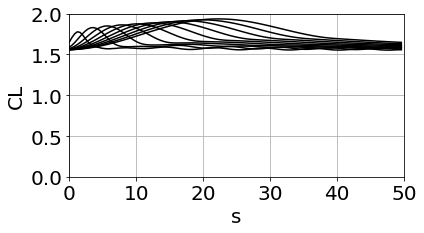

In [19]:
time = np.linspace(0, dt*(time_steps-1), time_steps-1)

fig, plotb = plt.subplots(1,1, figsize=(6, 3))
plotb.grid()
plotb.set_xlabel("s")
plotb.set_ylabel("CL")
for jGust in range(nGusts):
    plotb.plot(2*time*Vinf/chord, Force[jGust][1:]/(.5*rho*(Vinf*w0)*chord*aspect_ratio*2*np.pi), linestyle='-', c='black')
plotb.set(xlim=(0, 50), ylim=(0, 2))
#plt.show()
fig.savefig("figures/prismatic-gust-rho1-cl.eps",  format='eps', dpi=1000, bbox_inches='tight')

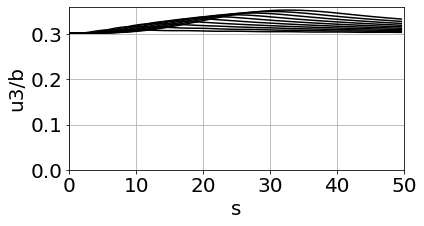

In [20]:
fig, plots = plt.subplots(1,1, figsize=(6, 3))
plots.grid()
plots.set_xlabel("s")
plots.set_ylabel("u3/b")
for jGust in range(nGusts):
    plots.plot(2*time*Vinf/chord, tip_pos[jGust][1:]/(chord*aspect_ratio), linestyle='-', c='black')
plots.set(xlim=(0, 50), ylim=(0, 0.36))
fig.savefig("figures/prismatic-gust-alpha10-tip.eps",  format='eps', dpi=1000, bbox_inches='tight')